In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!slim -d 'OUTPATH="pme.trees"' -d WIDTH=20 -d HEIGHT=2 -d NUMGENS=10000 -d DISPERSAL_SIGMA=0.2 -d SIGMA=0.2 pme.slim  >/dev/null

The system cannot find the path specified.


In [3]:
ts = pyslim.load("pme.trees")

In [4]:
print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │     983921║
╟───────────────┼───────────╢
║Sequence Length│100000000.0║
╟───────────────┼───────────╢
║Sample Nodes   │     991002║
╟───────────────┼───────────╢
║Total Size     │  130.3 MiB║
╚═══════════════╧═══════════╝
╔═══════════╤═══════╤════════╤════════════╗
║Table      │Rows   │Size    │Has Metadata║
╠═══════════╪═══════╪════════╪════════════╣
║Edges      │1978030│52.8 MiB│          No║
╟───────────┼───────┼────────┼────────────╢
║Individuals│ 495501│30.2 MiB│         Yes║
╟───────────┼───────┼────────┼────────────╢
║Migrations │      0│ 4 Bytes│          No║
╟───────────┼───────┼────────┼────────────╢
║Mutations  │      0│ 1.2 KiB│          No║
╟───────────┼───────┼────────┼────────────╢
║Nodes      │ 991002│32.1 MiB│         Yes║
╟───────────┼───────┼────────┼────────────╢
║Populations│      2│ 2.8 KiB│         Yes║
╟───────────┼───────┼────────┼────────────╢
║Provenanc

In [5]:
# Trace the path of each currently alive individual backward in time and record the location of the ancestor
# Return (time, x)
inds = ts.individuals_alive_at(0)
# Nodes (genomes) of current individuals
nodes = np.concatenate([ts.individual(i).nodes for i in inds])
# Times of nodes
node_times = ts.tables.nodes.time
# Individual corresponding to each node
node_indivs = ts.tables.nodes.individual
# Locations of individuals
locs = ts.individual_locations
paths = []
tree = ts.first()
for u in nodes:
    uind = node_indivs[u]
    out = [[node_times[u], locs[uind, 0]]]
    u = tree.parent(u)
    while u is not tskit.NULL:
        uind = node_indivs[u]
        out.append([node_times[u], locs[uind, 0]])
        u = tree.parent(u)
    paths.append(np.row_stack(out))
# Each element of paths is the lineage of one current individual

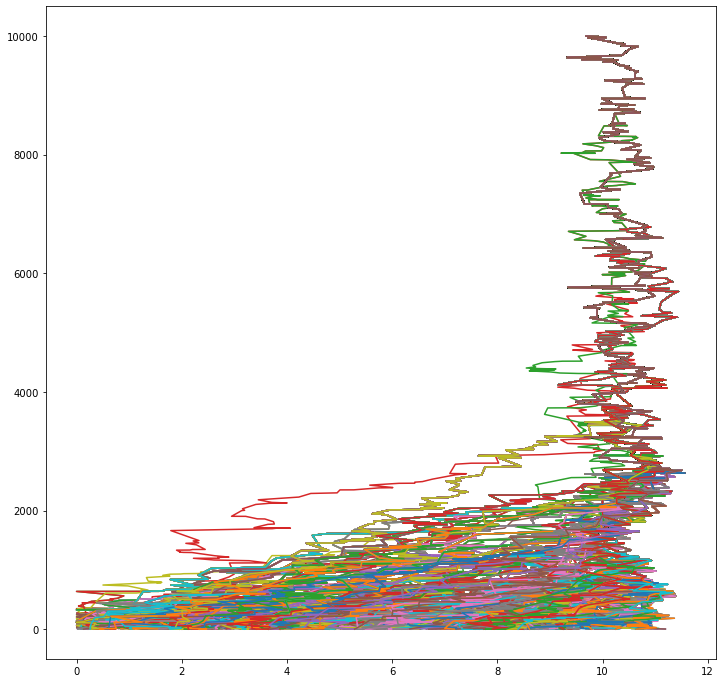

In [6]:
# Plot lineage locations over time
fig, ax = plt.subplots(figsize=(12, 12))
for path in paths:
    ax.plot(path[:,1], path[:,0])

In [7]:
# Calculate population density over time
times = np.linspace(0, 10000, 1000)
overall_popsize = []
for time in times:
    overall_popsize.append(len(ts.individuals_alive_at(time)))

[Text(0.5, 0, 'generation'), Text(0, 0.5, 'lineage location'), (0.0, 20.0)]

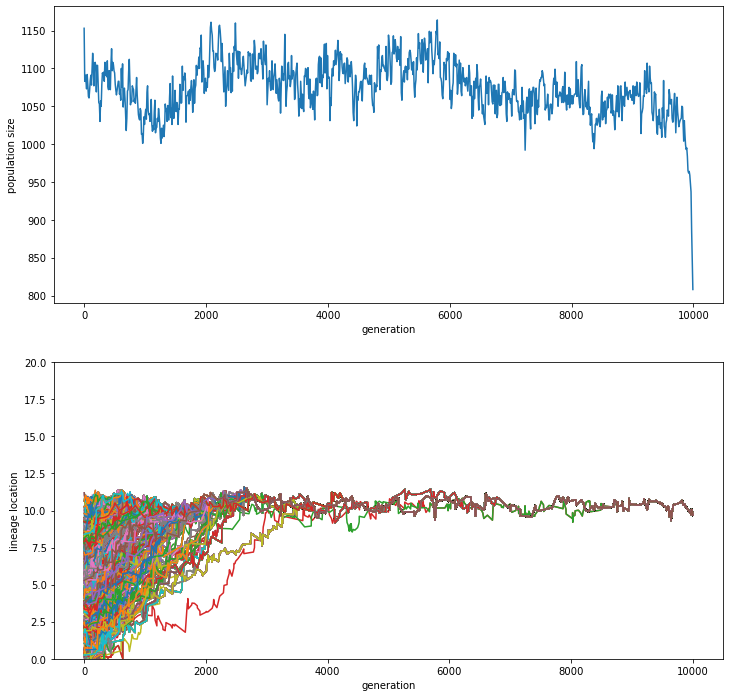

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
# Plot lineage locations over time
for path in paths:
    ax2.plot(path[:,0], path[:,1])
ax1.plot(times[:-1], overall_popsize[:-1])
ax1.set(xlabel = "generation", ylabel = "population size")
ax2.set(xlabel = "generation", ylabel = "lineage location", ylim = (0, 20))

In [9]:
# Calculate population density over time and space
times = np.linspace(0, 10000, 1000)
# intervals to calculate population density between
width = 20
loc_intervals = np.linspace(0, width, 20)
popsize = np.empty((len(loc_intervals) - 1, len(times)))
for i in range(len(times)):
    time = times[i]
    indivs = ts.individuals_alive_at(time)
    indiv_locations = ts.individual_locations[indivs]
    xloc = indiv_locations[:,0]
    popsize[::-1,i] = np.histogram(xloc, bins = loc_intervals)[0]

[Text(0.5, 0, 'generation'),
 Text(0, 0.5, 'location'),
 (0.0, 20.0),
 (0.0, 10000.0)]

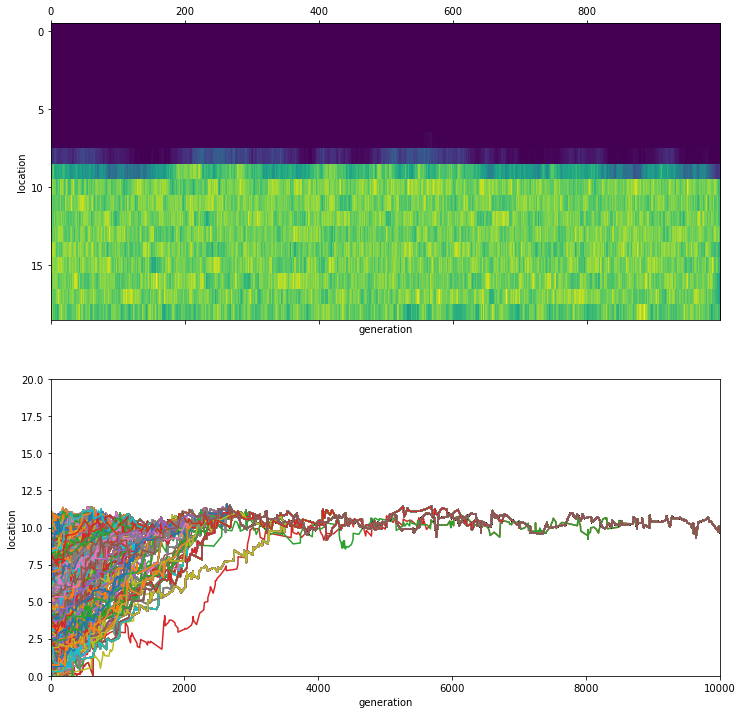

In [14]:
# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
# Plot lineage locations over time
for path in paths:
    ax2.plot(path[:,0], path[:,1])
ax1.matshow(np.array(popsize), aspect = 'auto')
ax1.set(xlabel = "generation", ylabel = "location")
ax2.set(xlabel = "generation", ylabel = "location", ylim = (0, 20), xlim = (0, 10000))